Epoch 1/25


2025-11-21 15:27:49.766214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - accuracy: 0.5033 - loss: 1.1207 - val_accuracy: 0.5942 - val_loss: 0.8428 - learning_rate: 0.0010
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.6809 - loss: 0.7615 - val_accuracy: 0.8551 - val_loss: 0.5275 - learning_rate: 0.0010
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.7467 - loss: 0.5998 - val_accuracy: 0.8261 - val_loss: 0.4589 - learning_rate: 0.0010
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7961 - loss: 0.5436 - val_accuracy: 0.8696 - val_loss: 0.4025 - learning_rate: 0.0010
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.8224 - loss: 0.4692 - val_accuracy: 0.9130 - val_loss: 0.3218 - learning_rate: 0.0010
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.8306 - loss: 0.4597 - val_accuracy: 0.8841 - val_loss: 0.3340 - learning_rate: 0.0010
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8835 - loss: 0.3543
Epoch 7: Red

2025-11-21 15:31:14.762484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


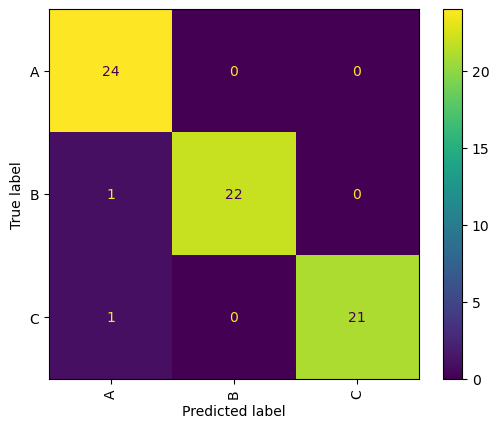

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.data import Dataset
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import EfficientNetB0, efficientnet

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# -----------------------------
# Setup
# -----------------------------
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16
IMG_SHAPE = (256, 256, 3)
NUM_CLASSES = 3

# -----------------------------
# 1. Load datasets
# -----------------------------
train_ds = Dataset.load('../data/processed/train')
val_ds = Dataset.load('../data/processed/val')

train_ds = (
    train_ds
    .batch(BATCH_SIZE, drop_remainder=True)
    .cache()
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .batch(BATCH_SIZE * 2, drop_remainder=False)
    .cache()
    .prefetch(AUTOTUNE)
)

# -----------------------------
# 2. Data augmentation
# -----------------------------
data_augmentor = keras.Sequential([
    layers.RandomFlip("horizontal", seed=RANDOM_SEED),
    layers.RandomRotation(0.15, seed=RANDOM_SEED),
    layers.RandomZoom(0.1, seed=RANDOM_SEED),
    layers.RandomTranslation(0.1, 0.1, seed=RANDOM_SEED),
    layers.RandomContrast(0.2, seed=RANDOM_SEED),
], name='augmentation_block')

# -----------------------------
# 3. Preprocessor for EfficientNet
# -----------------------------
preprocessor = layers.Lambda(efficientnet.preprocess_input, name='preprocessor')

# -----------------------------
# 4. Backbone (EfficientNetB0 with LOCAL pretrained weights)
# -----------------------------
feature_extractor = EfficientNetB0(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="../models/EfficientNetB0_notop.h5",  # <-- use this exact name
    name='efficientnet_backbone'
)
feature_extractor.trainable = False  # stage 1: frozen

# -----------------------------
# 5. Classification head
# -----------------------------
classifier = keras.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)
    ),
    layers.Dropout(0.5),
    layers.Dense(
        NUM_CLASSES,
        activation='softmax',
        kernel_regularizer=regularizers.l2(1e-4)
    )
], name='classification_head')

# -----------------------------
# 6. Full model
# -----------------------------
model = keras.Sequential([
    layers.Input(shape=IMG_SHAPE),
    data_augmentor,
    preprocessor,
    feature_extractor,
    classifier
], name='sign_efficientnet_pipeline')

# -----------------------------
# 7. Compile (stage 1)
# -----------------------------
loss_fn = keras.losses.SparseCategoricalCrossentropy()

adamw_optimizer = AdamW(
    learning_rate=1e-3,
    weight_decay=1e-5,
)

model.compile(
    optimizer=adamw_optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)

# -----------------------------
# 8. Callbacks for stage 1
# -----------------------------
es = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# -----------------------------
# 9. Train - Stage 1 (head only)
# -----------------------------
initial_epochs = 25

history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
    callbacks=[es, reduce_lr_cb]
)

# -----------------------------
# 10. Fine-tuning: unfreeze top of EfficientNet
# -----------------------------
feature_extractor.trainable = True

fine_tune_at = len(feature_extractor.layers) - 40  # unfreeze last ~40 layers
for layer in feature_extractor.layers[:fine_tune_at]:
    layer.trainable = False

fine_tune_lr = 1e-4
adamw_finetune = AdamW(
    learning_rate=fine_tune_lr,
    weight_decay=1e-5,
)

model.compile(
    optimizer=adamw_finetune,
    loss=loss_fn,
    metrics=['accuracy']
)

fine_tune_epochs = 15

# fresh callbacks for fine-tuning
es_ft = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr_cb_ft = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

history_fine = model.fit(
    train_ds,
    epochs=fine_tune_epochs,
    validation_data=val_ds,
    callbacks=[es_ft, reduce_lr_cb_ft]
)

# -----------------------------
# 11. Save competition model
# -----------------------------
model.save("../models/sign_efficientnet_competition.keras")

# -----------------------------
# 12. Evaluation on val_ds
# -----------------------------
test_probs = model.predict(val_ds)
test_preds = np.argmax(test_probs, axis=1)

# Extract true labels
y_test_batches = [y for x, y in val_ds]
y_test = np.concatenate(y_test_batches)

class_names = ['A', 'B', 'C']

print(classification_report(y_test, test_preds, target_names=class_names))

ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=test_preds,
    display_labels=class_names,
    xticks_rotation='vertical'
)
plt.show()

In [3]:
import os
print(os.listdir("../models"))

['trained_model.keras']


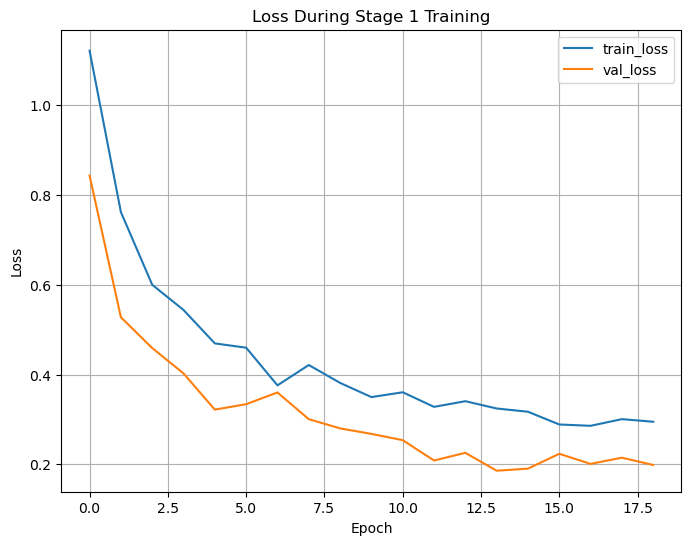

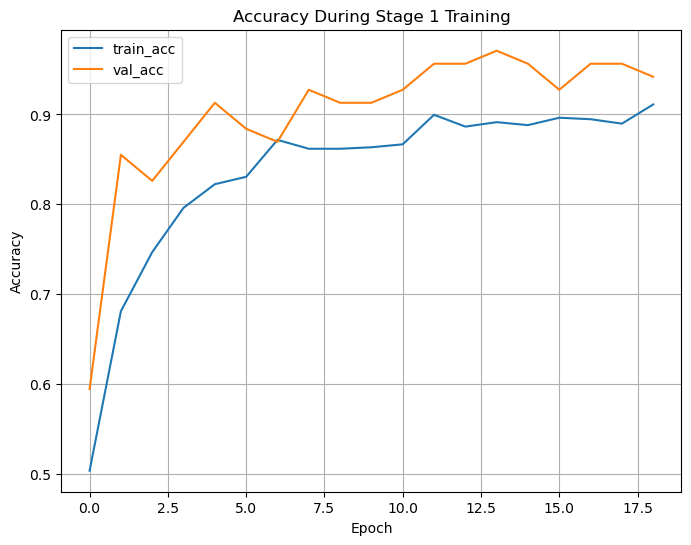

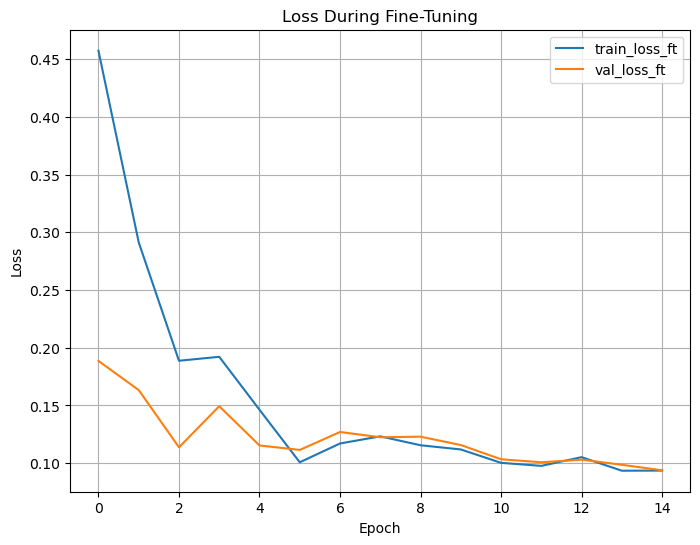

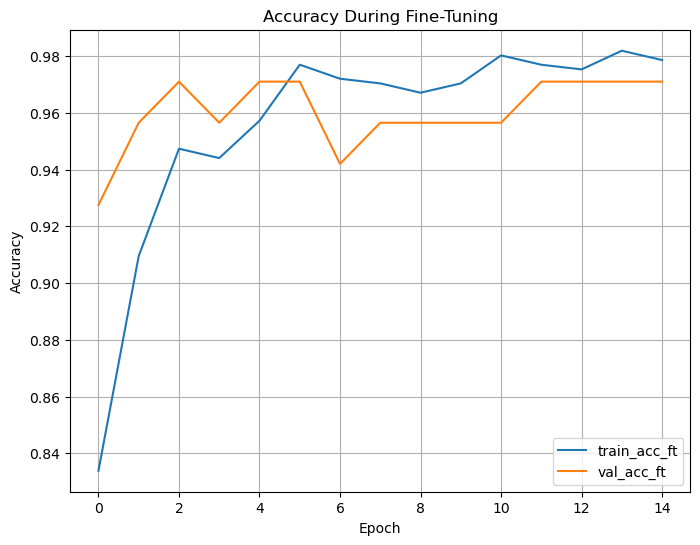

2025-11-21 15:40:20.899966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


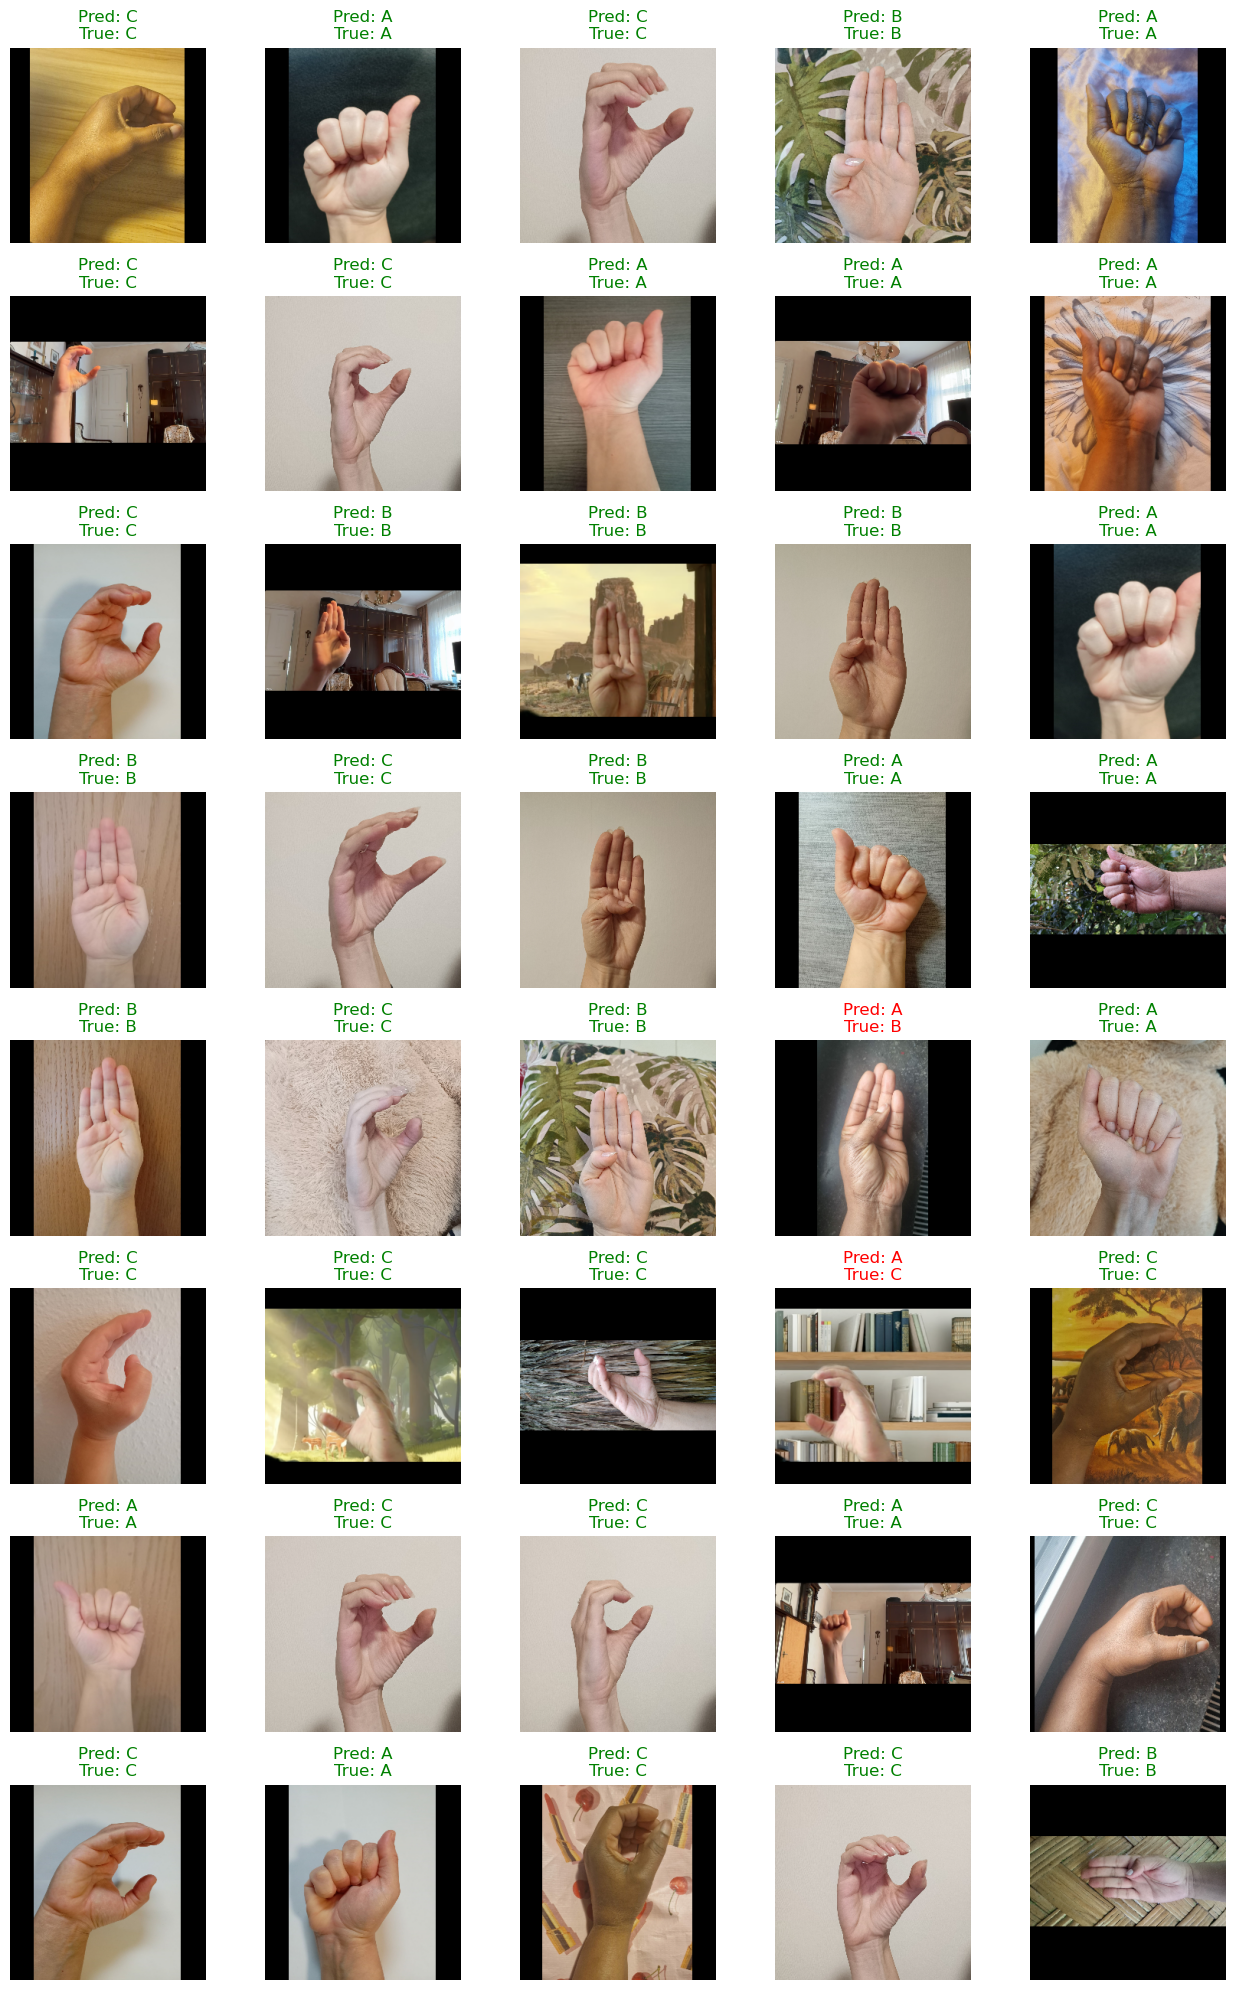

In [6]:

# ============================================
# 13. Training Curves (Loss + Accuracy)
# ============================================

# Loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss During Stage 1 Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy During Stage 1 Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# If you want curves from fine-tuning:
plt.figure(figsize=(8, 6))
plt.plot(history_fine.history['loss'], label='train_loss_ft')
plt.plot(history_fine.history['val_loss'], label='val_loss_ft')
plt.title("Loss During Fine-Tuning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history_fine.history['accuracy'], label='train_acc_ft')
plt.plot(history_fine.history['val_accuracy'], label='val_acc_ft')
plt.title("Accuracy During Fine-Tuning")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# ============================================
# 14. Visualising First 40 Predictions
# ============================================

num_vis = 40

# Extract images from val_ds
batched_test_images = [X_batch for X_batch, y_batch in val_ds]
test_images = np.concatenate(batched_test_images)

plt.figure(figsize=(int(num_vis/3), int(num_vis/2)))
columns = 5

for i in range(num_vis):
    plt.subplot(int(num_vis/columns), columns, i+1)
    plt.imshow(test_images[i].astype('uint8'))
    pred = test_preds[i]
    true = y_test[i]
    color = 'green' if pred == true else 'red'
    plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[true]}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()